In [83]:
# Import helper functions
%run helper.py


def print_histogram(data, label=[]):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,7))
    plt.hist(data, bins=81)
    #plt.xticks( np.arange(n_classes) )
    #plt.xticks(np.arange(n_classes), np.bincount(y_train))
    plt.xlabel('Steering angle')
    plt.ylabel('Number of samples')
    if label != []:
        plt.legend([label], fontsize='xx-large')
    plt.show()
    return

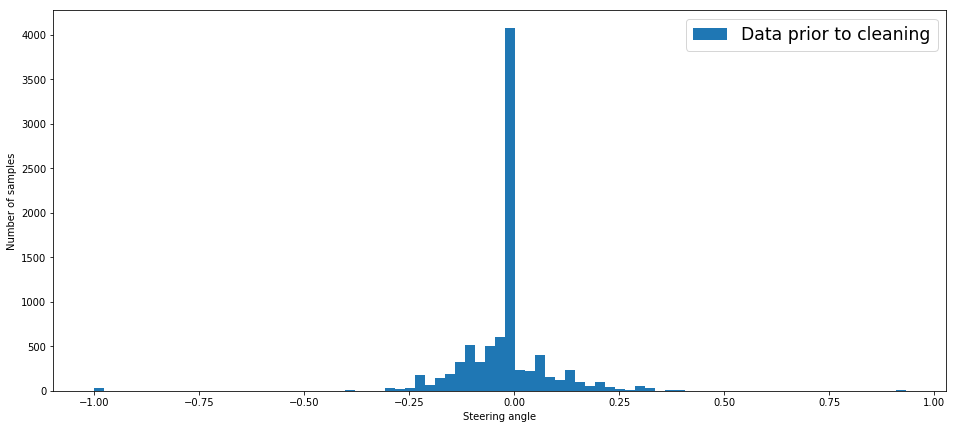

Number of samples in input data: 8859
Samples going straight: 3202 , Samples steering:  5657
Number of random samples going straight that are rescued ( 10.0 % ): 320
Number after dropping large steering angles ( larger than +- 2.0 ): 5657
Number of cleaned samples with rescued samples:  5977


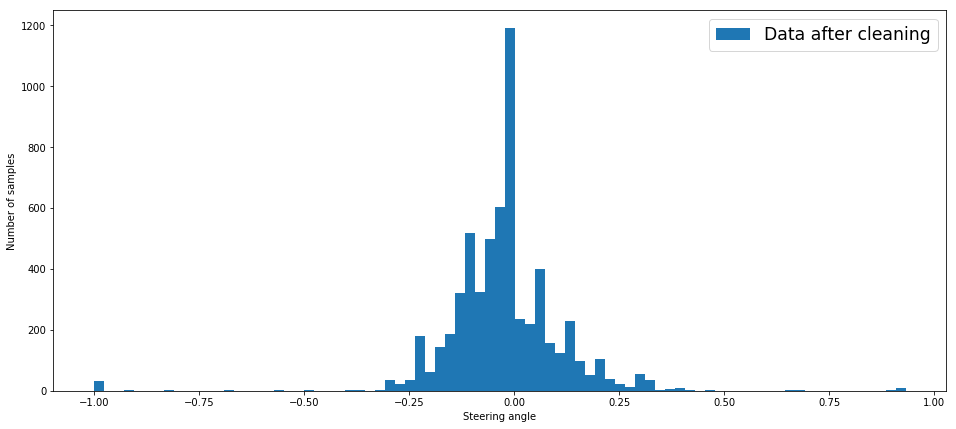

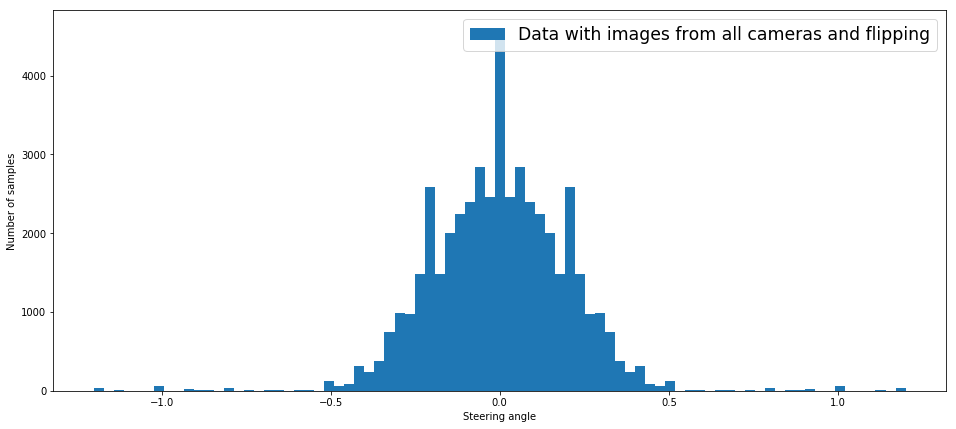

In [84]:
paths = ['../Driving_Data/']
driving_log = read_csv(paths)
a = driving_log['Steering Angle'].values
print_histogram(driving_log['Steering Angle'].values, 'Data prior to cleaning')
driving_log = clean_data(driving_log, upper_angle=2.0, zero_frac=0.1)
print_histogram(driving_log['Steering Angle'].values, 'Data after cleaning')

a=[]
a = driving_log['Steering Angle'].values
a = np.append(a,-a)
a = np.append(a, a+0.2)
a = np.append(a, a-0.2)
print_histogram(a, 'Data with images from all cameras and flipping')


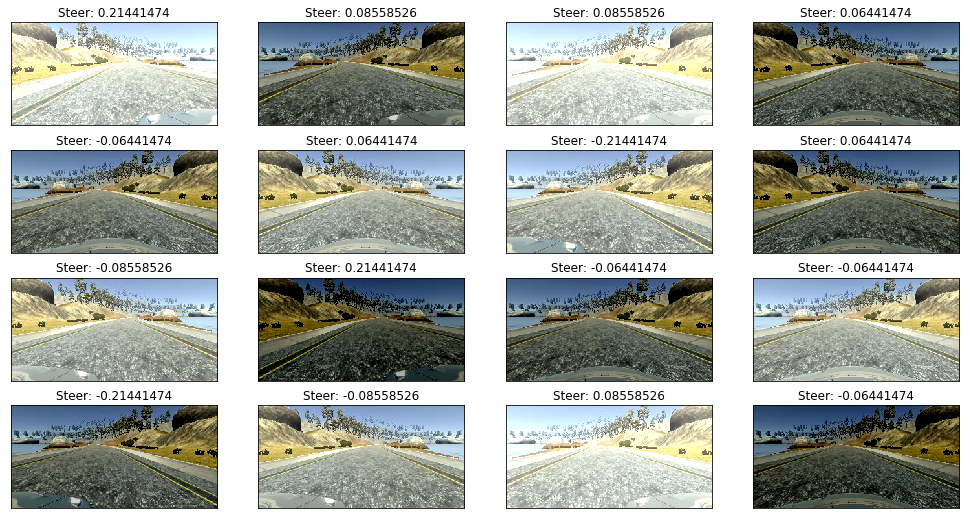

In [89]:
# demonstrator of how generator works
paths = ['../Driving_Data/']
driving_log = read_csv(paths)
index = 85

plt.figure(figsize=(17,9))

for n in range(16):
    image, steering_angle = load_and_augment_image(driving_log.loc[index])
    image = img_to_array(image)/255
    plt.subplot(4,4,n+1)
    
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap="gray")
    plt.title('Steer: ' + str(steering_angle))
    
plt.show()

#print(driving_log.loc[27])
